# Task 1 — Customer Segmentation Using Clustering (Credit Dataset-[4038].csv)

**Organisation:** Aims Analytics (Banking)  
**Purpose:** Segment customers into affinity groups using clustering to support personalised marketing and product strategy.  

**Analyst:** Md Moynul Arefin  
**Student ID:** STU96523


## 1. Introduction

I joined Aims Analytics, a start-up using data science to improve customer experience in the banking sector.  
This task uses unsupervised learning (clustering) to group customers into meaningful affinity segments. These segments can support targeted marketing, personalised recommendations, and improved customer engagement.

**Dataset:** `Credit Dataset - [4038].csv`


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)



## 2. Dataset Overview

This dataset contains customer demographic and financial variables suitable for segmentation:

- `customer_id` (identifier only; excluded from clustering)
- `credit_score`, `age`, `tenure`, `balance`, `estimated_salary`
- `country`, `gender`


In [37]:
# If your file name/path is different, update it here:
DATA_PATH = "/content/Credit Dataset - [4038].csv"

df = pd.read_csv(DATA_PATH)

print("Loaded:", DATA_PATH)
print("Shape (rows, cols):", df.shape)
display(df.head())


Loaded: /content/Credit Dataset - [4038].csv
Shape (rows, cols): (2020, 9)


,customer_id,credit_score,country,gender,age,tenure,balance,estimated_salary,Unnamed: 8
0,1563462,619.0,France,Female,42.0,2.0,NaN,11348.88,NaN
1,15647311,68.0,Spain,Female,41.0,1.0,8387.86,112542.58,NaN
2,1561934,52.0,France,Female,42.0,8.0,15966.80,113931.57,NaN
3,1571354,699.0,France,Female,39.0,1.0,3423.00,93826.63,NaN
4,15737888,85.0,Spain,Female,43.0,2.0,12551.82,7984.10,NaN


## 3. Data Pre-processing: Data Quality Checks

Checks performed before modelling:
- remove export artefacts (e.g., “Unnamed” columns)
- check and remove duplicate rows (if present)
- quantify missing values to guide imputation


In [38]:
# 3.1 Quick structure and types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       2020 non-null   int64  
 1   credit_score      2009 non-null   float64
 2   country           2020 non-null   object 
 3   gender            2020 non-null   object 
 4   age               2014 non-null   float64
 5   tenure            1938 non-null   float64
 6   balance           1317 non-null   float64
 7   estimated_salary  2020 non-null   float64
 8   Unnamed: 8        0 non-null      float64
dtypes: float64(6), int64(1), object(2)
memory usage: 142.2+ KB


In [39]:
# 3.2 Remove export artefacts like "Unnamed: x" columns (common in CSV exports)
unnamed_cols = [c for c in df.columns if "Unnamed" in str(c)]
print("Unnamed columns found:", unnamed_cols)

df = df.drop(columns=unnamed_cols, errors="ignore")
print("Shape after dropping Unnamed columns:", df.shape)


Unnamed columns found: ['Unnamed: 8']
Shape after dropping Unnamed columns: (2020, 8)


In [40]:
# 3.3 Duplicate row check
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

if dup_count > 0:
    df = df.drop_duplicates()
    print("Shape after dropping duplicates:", df.shape)


Duplicate rows: 0


In [41]:
# 3.4 Missing values summary (count + percentage)
missing_count = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_count / len(df) * 100).round(2)

missing_table = pd.DataFrame({
    "missing_count": missing_count,
    "missing_pct": missing_pct
})
missing_table = missing_table[missing_table["missing_count"] > 0]
display(missing_table)


,missing_count,missing_pct
balance,703,34.80
tenure,82,4.06
credit_score,11,0.54
age,6,0.30


## 4. Exploratory Data Analysis (EDA)

A brief EDA to understand distributions and categorical breakdowns before modelling.


In [47]:
# 4.1 Summary statistics (numerical columns)
print(df.describe())

        customer_id  credit_score          age       tenure       balance  estimated_salary
count  2.020000e+03   2009.000000  2014.000000  1938.000000  1.317000e+03       2020.000000
mean   9.593544e+06    525.802887    35.508937     4.858101  9.413643e+04      67223.410317
std    7.142025e+06    248.621152    14.029019     2.655002  4.135185e+05      64795.973787
min    1.567000e+03      5.000000     2.000000     1.000000  1.950000e+01          6.360000
25%    1.569085e+06    486.000000    29.000000     2.000000  1.276480e+04       9985.462500
50%    1.559484e+07    618.000000    36.000000     5.000000  8.227535e+04      44250.070000
75%    1.571238e+07    694.000000    43.000000     7.000000  1.294333e+05     124809.885000
max    1.581536e+07    849.000000    82.000000     9.000000  1.431293e+07     222626.980000


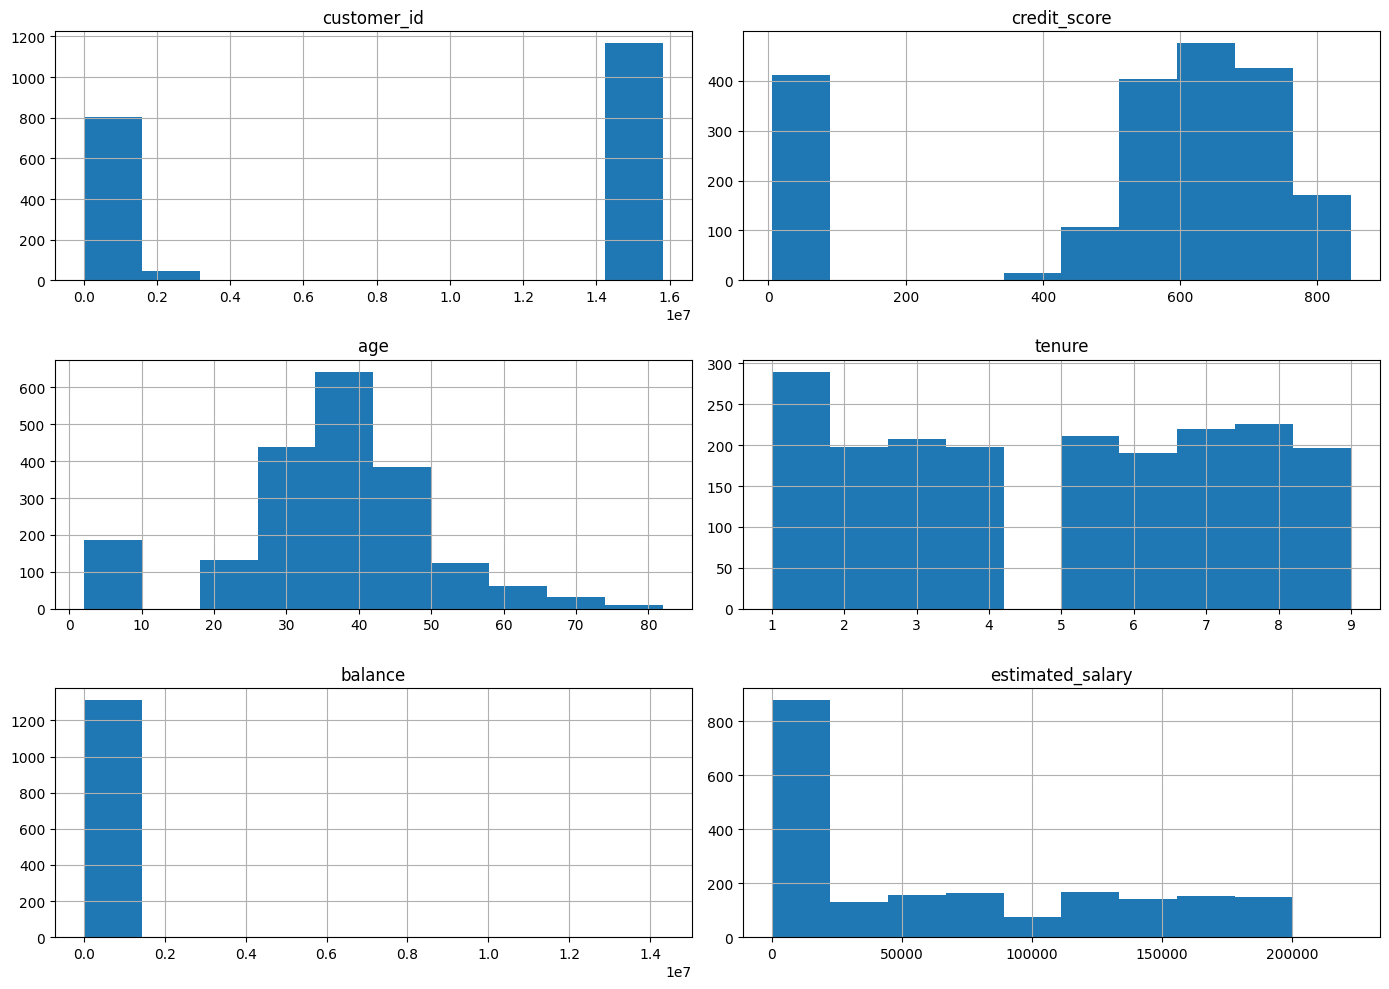

In [9]:
# 4.2 Histograms for numerical features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

df[num_cols].hist(figsize=(14, 10))
plt.tight_layout()
plt.show()


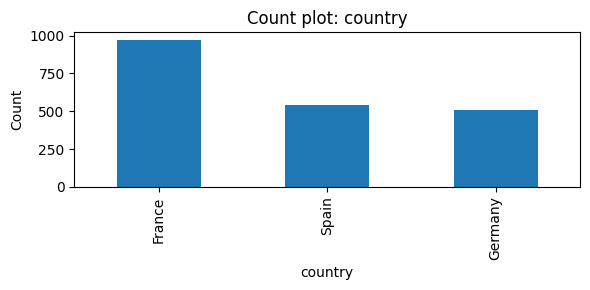

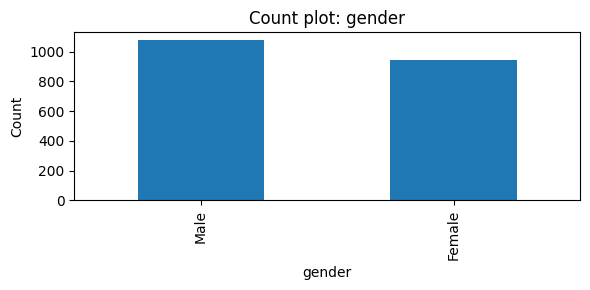

In [10]:
# 4.3 Distributions for categorical features (counts)
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in cat_cols:
    ax = df[c].value_counts(dropna=False).plot(kind="bar", figsize=(6,3))
    ax.set_title(f"Count plot: {c}")
    ax.set_xlabel(c)
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()


## 5. Feature Selection and Pre-processing

`customer_id` is excluded from clustering because it is an identifier, not a behavioural feature.  
Numerical and categorical features are prepared using imputation, one-hot encoding, and scaling.


In [11]:
ID_COL = "customer_id"  # identifier only (not a clustering feature)

# Build feature matrix for clustering
feature_cols = [c for c in df.columns if c != ID_COL]
X = df[feature_cols].copy()

print("Clustering features:", feature_cols)
display(X.head())


Clustering features: ['credit_score', 'country', 'gender', 'age', 'tenure', 'balance', 'estimated_salary']


,credit_score,country,gender,age,tenure,balance,estimated_salary
0,619.0,France,Female,42.0,2.0,NaN,11348.88
1,68.0,Spain,Female,41.0,1.0,8387.86,112542.58
2,52.0,France,Female,42.0,8.0,15966.80,113931.57
3,699.0,France,Female,39.0,1.0,3423.00,93826.63
4,85.0,Spain,Female,43.0,2.0,12551.82,7984.10


In [12]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

X_processed = preprocessor.fit_transform(X)

print("Processed feature matrix shape:", X_processed.shape)


Numeric features: ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
Categorical features: ['country', 'gender']
Processed feature matrix shape: (2020, 10)


## 6. Dimensionality Reduction (PCA)

PCA is used only to create a 2D visualisation of the processed feature space.


In [13]:
# Convert to dense only if needed (safe for this dataset size)
X_dense = X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense)

print("Explained variance ratio (PC1, PC2):", np.round(pca.explained_variance_ratio_, 4))
print("Total explained (2 PCs):", round(float(pca.explained_variance_ratio_.sum()), 4))


Explained variance ratio (PC1, PC2): [0.1739 0.166 ]
Total explained (2 PCs): 0.3399


## 7. Clustering Model 1: K-Means

Select the number of clusters using Silhouette Score, then fit the final K-Means model and visualise clusters using PCA.


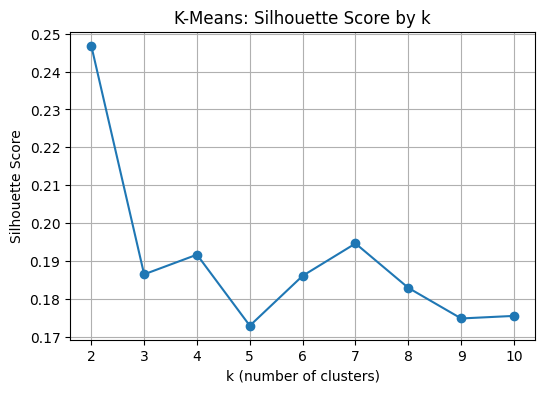

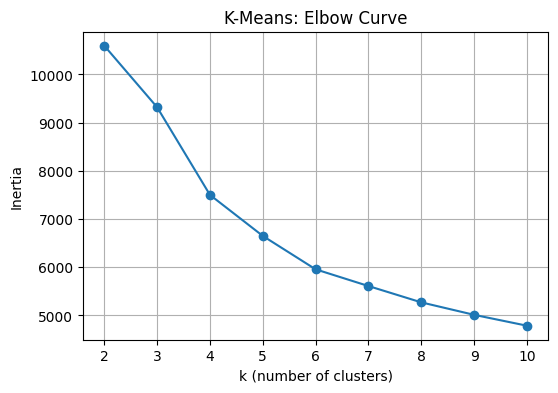

Best k by Silhouette: 2 | Silhouette: 0.2468


In [14]:
k_values = range(2, 11)
kmeans_sil = []
kmeans_inertia = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_processed)
    kmeans_sil.append(silhouette_score(X_processed, labels))
    kmeans_inertia.append(km.inertia_)

# Silhouette vs k
plt.figure(figsize=(6,4))
plt.plot(list(k_values), kmeans_sil, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Silhouette Score")
plt.title("K-Means: Silhouette Score by k")
plt.grid(True)
plt.show()

# Elbow (inertia) vs k
plt.figure(figsize=(6,4))
plt.plot(list(k_values), kmeans_inertia, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia")
plt.title("K-Means: Elbow Curve")
plt.grid(True)
plt.show()

best_k = int(list(k_values)[int(np.argmax(kmeans_sil))])
print("Best k by Silhouette:", best_k, "| Silhouette:", round(float(max(kmeans_sil)), 4))


Final K-Means Silhouette: 0.2468


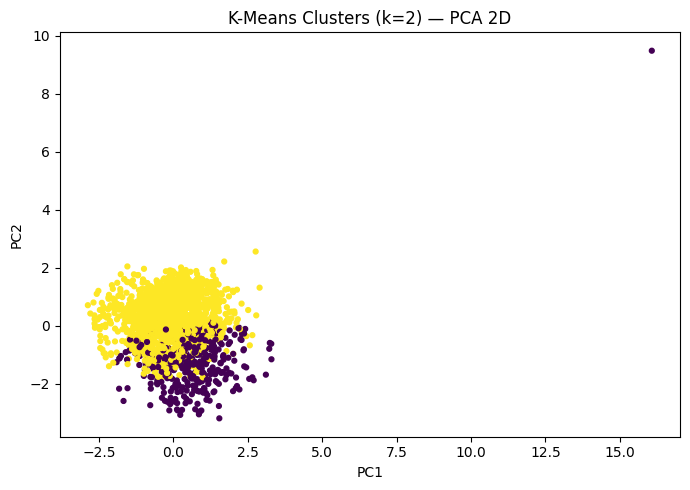

In [15]:
# Train final K-Means
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_processed)
sil_kmeans = silhouette_score(X_processed, labels_kmeans)

print("Final K-Means Silhouette:", round(float(sil_kmeans), 4))

# PCA plot
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, s=12)
plt.title(f"K-Means Clusters (k={best_k}) — PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


## 8. Clustering Model 2: Hierarchical (Agglomerative)

Test a range of cluster counts using Silhouette Score, fit the final model, and visualise clusters using PCA.


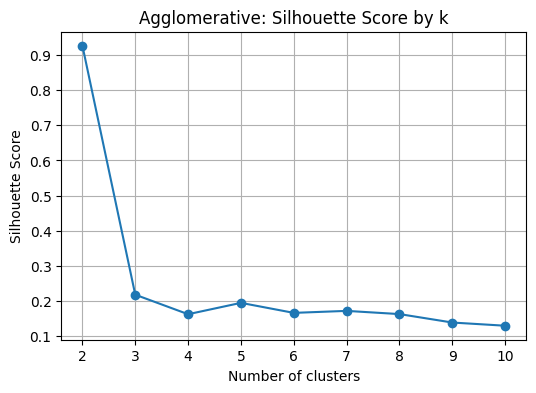

Best k (Agglomerative): 2 | Silhouette: 0.9268


In [16]:
agg_k_values = range(2, 11)
agg_sil_scores = []

for k in agg_k_values:
    agg = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = agg.fit_predict(X_dense)
    agg_sil_scores.append(silhouette_score(X_processed, labels))

plt.figure(figsize=(6,4))
plt.plot(list(agg_k_values), agg_sil_scores, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Agglomerative: Silhouette Score by k")
plt.grid(True)
plt.show()

best_agg_k = int(list(agg_k_values)[int(np.argmax(agg_sil_scores))])
print("Best k (Agglomerative):", best_agg_k, "| Silhouette:", round(float(max(agg_sil_scores)), 4))


Final Agglomerative Silhouette: 0.9268


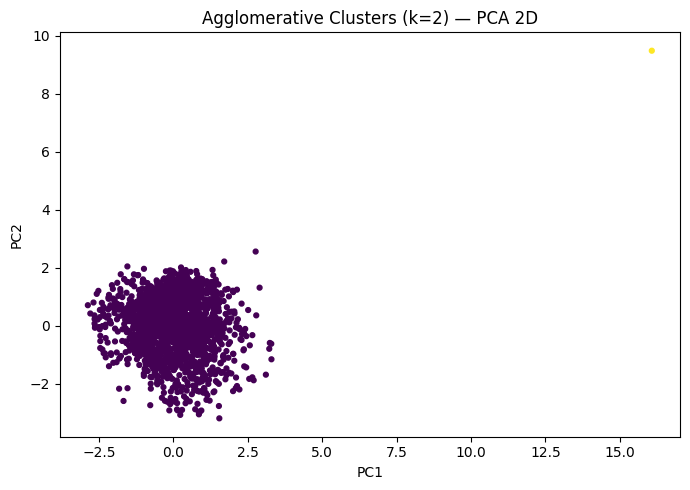

In [17]:
agg_final = AgglomerativeClustering(n_clusters=best_agg_k, linkage="ward")
labels_agg = agg_final.fit_predict(X_dense)
sil_agg = silhouette_score(X_processed, labels_agg)

print("Final Agglomerative Silhouette:", round(float(sil_agg), 4))

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_agg, s=12)
plt.title(f"Agglomerative Clusters (k={best_agg_k}) — PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


## 9. Clustering Model 3: DBSCAN

DBSCAN is density-based and can label outliers as noise. A small parameter search is used, and Silhouette Score is calculated on non-noise points only.


In [18]:
eps_values = [0.3, 0.5, 0.7, 1.0, 1.2]
min_samples_values = [5, 10, 15]

dbscan_rows = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_dense)

        # clusters exclude noise (-1)
        n_clusters = len(set(labels)) - (1 if -1 in set(labels) else 0)
        n_noise = int(np.sum(labels == -1))

        # silhouette only on non-noise, with at least 2 clusters
        mask = labels != -1
        sil = np.nan
        if n_clusters >= 2 and mask.sum() > 10:
            sil = silhouette_score(X_dense[mask], labels[mask])

        dbscan_rows.append((eps, ms, n_clusters, n_noise, sil))

dbscan_df = pd.DataFrame(
    dbscan_rows,
    columns=["eps", "min_samples", "n_clusters", "n_noise", "silhouette_non_noise"]
).sort_values(by="silhouette_non_noise", ascending=False)

display(dbscan_df.head(15))


,eps,min_samples,n_clusters,n_noise,silhouette_non_noise
0,0.3,5,4,1998,0.739533
4,0.5,10,9,1794,0.352523
8,0.7,15,7,1422,0.238203
11,1.0,15,10,571,0.186638
3,0.5,5,32,1416,0.177018
14,1.2,15,10,371,0.175369
7,0.7,10,11,1127,0.171394
10,1.0,10,17,360,0.159037
13,1.2,10,12,221,0.151674
9,1.0,5,28,143,0.122455


Best DBSCAN parameters: eps = 0.3 , min_samples = 5
Clusters (excluding noise): 4
Noise points: 1998
DBSCAN Silhouette (non-noise): 0.7395


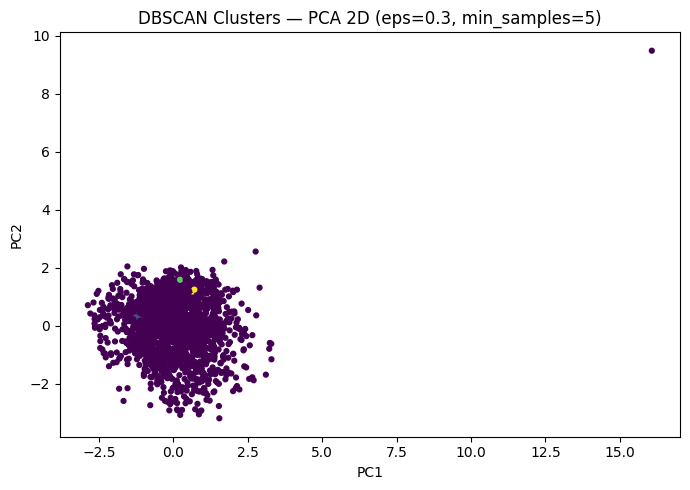

In [19]:
# Train the best DBSCAN model (if a valid silhouette exists)
dbscan_best = None
sil_dbscan = np.nan
labels_dbscan = None

valid = dbscan_df.dropna()
if len(valid) == 0:
    print("DBSCAN: No stable parameter setting produced >=2 clusters with a valid silhouette in this grid.")
else:
    best_eps = float(valid.iloc[0]["eps"])
    best_ms = int(valid.iloc[0]["min_samples"])

    dbscan_best = DBSCAN(eps=best_eps, min_samples=best_ms)
    labels_dbscan = dbscan_best.fit_predict(X_dense)

    mask = labels_dbscan != -1
    sil_dbscan = silhouette_score(X_dense[mask], labels_dbscan[mask])

    print("Best DBSCAN parameters: eps =", best_eps, ", min_samples =", best_ms)
    print("Clusters (excluding noise):", len(set(labels_dbscan)) - (1 if -1 in set(labels_dbscan) else 0))
    print("Noise points:", int(np.sum(labels_dbscan == -1)))
    print("DBSCAN Silhouette (non-noise):", round(float(sil_dbscan), 4))

    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, s=12)
    plt.title(f"DBSCAN Clusters — PCA 2D (eps={best_eps}, min_samples={best_ms})")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()


## 10. Model Evaluation, Comparison and Recommendation

Compare models using Silhouette Score and recommend the most suitable model for this dataset.


In [20]:
results = [
    {"model": "K-Means", "params": f"k={best_k}", "silhouette": float(sil_kmeans)},
    {"model": "Agglomerative (Ward)", "params": f"k={best_agg_k}", "silhouette": float(sil_agg)},
]

if labels_dbscan is not None:
    results.append({"model": "DBSCAN (non-noise)", "params": f"eps={best_eps}, min_samples={best_ms}", "silhouette": float(sil_dbscan)})
else:
    results.append({"model": "DBSCAN", "params": "No valid setting in grid", "silhouette": np.nan})

results_df = pd.DataFrame(results).sort_values(by="silhouette", ascending=False)
display(results_df)


,model,params,silhouette
1,Agglomerative (Ward),k=2,0.926759
2,DBSCAN (non-noise),"eps=0.3, min_samples=5",0.739533
0,K-Means,k=2,0.246832


In [21]:
best_row = results_df.dropna().sort_values("silhouette", ascending=False).head(1)
best_model = best_row["model"].iloc[0]
best_params = best_row["params"].iloc[0]
best_sil = float(best_row["silhouette"].iloc[0])

print("✅ Recommended model (by Silhouette):", best_model)
print("   Parameters:", best_params)
print("   Silhouette:", round(best_sil, 4))


✅ Recommended model (by Silhouette): Agglomerative (Ward)
   Parameters: k=2
   Silhouette: 0.9268


## 11. Cluster Profiling and Characteristics

Attach final cluster labels back to the original data and profile clusters using summary statistics and cluster sizes.


In [22]:
# Attach labels for the selected model
df_profile = df.copy()

if best_model == "K-Means":
    df_profile["cluster"] = labels_kmeans
elif best_model.startswith("Agglomerative"):
    df_profile["cluster"] = labels_agg
else:
    df_profile["cluster"] = labels_dbscan  # includes -1 noise

display(df_profile.head())


,customer_id,credit_score,country,gender,age,tenure,balance,estimated_salary,cluster
0,1563462,619.0,France,Female,42.0,2.0,NaN,11348.88,0
1,15647311,68.0,Spain,Female,41.0,1.0,8387.86,112542.58,0
2,1561934,52.0,France,Female,42.0,8.0,15966.80,113931.57,0
3,1571354,699.0,France,Female,39.0,1.0,3423.00,93826.63,0
4,15737888,85.0,Spain,Female,43.0,2.0,12551.82,7984.10,0


,count
cluster,
0,2019
1,1


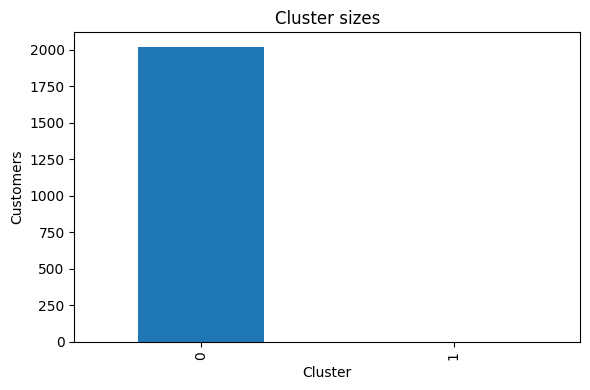

In [23]:
# Cluster sizes
cluster_sizes = df_profile["cluster"].value_counts().sort_index()
display(cluster_sizes)

plt.figure(figsize=(6,4))
cluster_sizes.plot(kind="bar")
plt.title("Cluster sizes")
plt.xlabel("Cluster")
plt.ylabel("Customers")
plt.tight_layout()
plt.show()


In [24]:
# Numeric profile: mean + median
profile_num_cols = [c for c in ["credit_score", "age", "tenure", "balance", "estimated_salary"] if c in df_profile.columns]

num_profile = df_profile.groupby("cluster")[profile_num_cols].agg(["count", "mean", "median", "min", "max"])
display(num_profile)


credit_score                                   age                               tenure                           balance                                                    estimated_salary  \
               count       mean median    min    max count       mean median   min   max  count     mean median  min  max   count          mean       median         min         max            count   
cluster                                                                                                                                                                                                 
0               2008  525.75996  618.0    5.0  849.0  2013  35.504223   36.0   2.0  82.0   1937  4.85906    5.0  1.0  9.0    1316  8.333188e+04     82267.32        19.5   2226291.0             2019   
1                  1  612.00000  612.0  612.0  612.0     1  45.000000   45.0  45.0  45.0      1  3.00000    3.0  3.0  3.0       1  1.431293e+07  14312933.00  14312933.0  14312933.0                1   

                                                      
                 mean    median       min        max  
cluster                                               
0        67226.330649  44244.49      6.36  222626.98  
1        61327.260000  61327.26  61327.26   61327.26

In [25]:
# Categorical profile: most frequent category per cluster (if columns exist)
cat_profile_cols = [c for c in ["country", "gender"] if c in df_profile.columns]

def mode_or_nan(s):
    s = s.dropna()
    return s.mode().iloc[0] if len(s) else np.nan

cat_profile = df_profile.groupby("cluster")[cat_profile_cols].agg(mode_or_nan) if cat_profile_cols else pd.DataFrame()
display(cat_profile)


,country,gender
cluster,,
0,France,Male
1,Germany,Male


In [27]:
# A compact cluster profile table (easy to copy into a report)
cluster_profile_table = pd.DataFrame({
    "cluster_size": cluster_sizes
})

for col in profile_num_cols:
    cluster_profile_table[f"{col}_mean"] = df_profile.groupby("cluster")[col].mean()
    cluster_profile_table[f"{col}_median"] = df_profile.groupby("cluster")[col].median()

for col in cat_profile_cols:
    cluster_profile_table[f"{col}_mode"] = df_profile.groupby("cluster")[col].apply(mode_or_nan)

display(cluster_profile_table)


,cluster_size,credit_score_mean,credit_score_median,age_mean,age_median,tenure_mean,tenure_median,balance_mean,balance_median,estimated_salary_mean,estimated_salary_median,country_mode,gender_mode
cluster,,,,,,,,,,,,,
0,2019,525.75996,618.0,35.504223,36.0,4.85906,5.0,8.333188e+04,82267.32,67226.330649,44244.49,France,Male
1,1,612.00000,612.0,45.000000,45.0,3.00000,3.0,1.431293e+07,14312933.00,61327.260000,61327.26,Germany,Male
